In [2]:
import samtools
samtools.autocorrect(working_dir='C:/Users/Samuel_DeLap.UMLADCO/Documents/Abu-Zahra/SQ03Cadaver')

Total frames in video: 1498.0
Current Frame: 1
Current Frame: 2
Current Frame: 3
Current Frame: 4
Current Frame: 5
Current Frame: 6
Current Frame: 7
Current Frame: 8
Current Frame: 9
Current Frame: 10
Current Frame: 11
Current Frame: 12
Current Frame: 13
Current Frame: 14
Current Frame: 15
Current Frame: 16
Current Frame: 17
Current Frame: 18
Current Frame: 19
Current Frame: 20
Current Frame: 21
Current Frame: 22
Current Frame: 23
Current Frame: 24
Current Frame: 25
Current Frame: 26
Current Frame: 27
Current Frame: 28
Current Frame: 29
Current Frame: 30
Current Frame: 31
Current Frame: 32
Current Frame: 33
Current Frame: 34
Current Frame: 35
Current Frame: 36
Current Frame: 37
Current Frame: 38
Current Frame: 39
Current Frame: 40
Current Frame: 41
Current Frame: 42
Current Frame: 43
Current Frame: 44
Current Frame: 45
Current Frame: 46
Current Frame: 47
Current Frame: 48
Current Frame: 49
Current Frame: 50
Current Frame: 51
Current Frame: 52
Current Frame: 53
Current Frame: 54
Current

Analyzing video at: C:/Users/Samuel_DeLap.UMLADCO/Documents/Abu-Zahra/SQ03Cadaver/trials/18NOV2022SQ3Trial_01/18NOV2022SQ3Trial_01_cam1.avi
Loading cam1 video for trial 18NOV2022SQ3Trial_01
Total frames in video: 1498
Raw


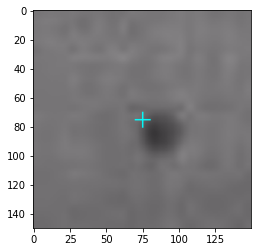

Filtered


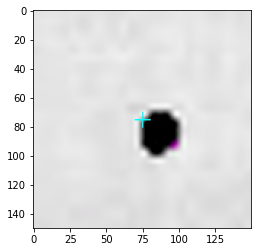

Blurred: 25.632343753043564


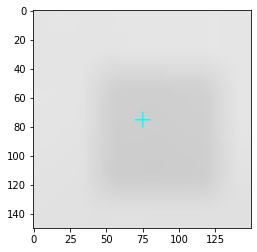

Diff (Float - blurred)


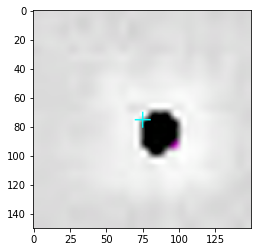

Median


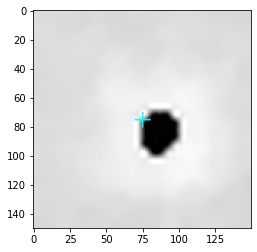

Median filtered


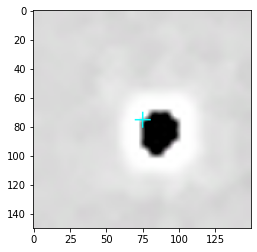

Threshold


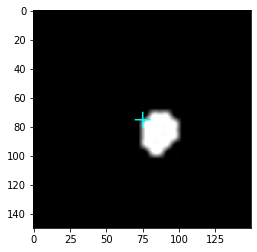

Gaussian


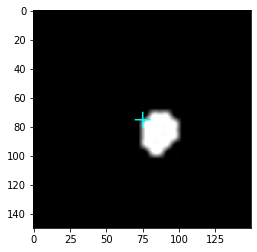

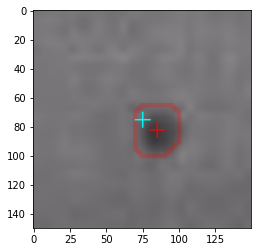

In [12]:
import samtools
import math
import os
import cv2
import numpy as np
import pandas as pd

# Function params
working_dir = 'C:/Users/Samuel_DeLap.UMLADCO/Documents/Abu-Zahra/SQ03Cadaver'
cam = 'cam1'
part = 'marker001'
frame_num = 1
hdf_path = 'C:/Users/Samuel_DeLap.UMLADCO/Documents/Abu-Zahra/SQ03Cadaver/trials/18NOV2022SQ3Trial_01/it0/18NOV2022SQ3Trial_01-Predicted2DPoints.h5'
krad = 17
gsigma = 10
img_wt = 3.6
blur_wt = -2.9
gamma = 0.1

new_data_path = working_dir + "/trials"
trial_name = os.listdir(new_data_path)[0]
predicted_vid_path = new_data_path + '/' + trial_name + '/' + trial_name + '_' + cam + '.avi'
print(f'Analyzing video at: {predicted_vid_path}')
# Find the raw video
try:
    video = cv2.VideoCapture(predicted_vid_path)
except FileNotFoundError:
    raise FileNotFoundError(f'Please make sure that your {cam} video file is named {trial_name}_{cam}.avi') from None
# For each frame of video
print(f'Loading {cam} video for trial {trial_name}')
print(f'Total frames in video: {int(video.get(cv2.CAP_PROP_FRAME_COUNT))}')

# Load frame
video.set(1, frame_num - 1)
ret, sample_frame = video.read()
if ret is False:
    raise IOError('Error reading video frame')

x_float = hdf.loc[frame_num, part + '_' + cam + '_X']
y_float = hdf.loc[frame_num, part + '_' + cam + '_Y']
x_start = int(x_float-15+0.5)
y_start = int(y_float-15+0.5)
x_end = int(x_float+15+0.5)
y_end = int(y_float+15+0.5)

subimage = sample_frame[y_start:y_end, x_start:x_end]

print('Raw')
samtools.show_crop(subimage, 15)
subimage_filtered = samtools.filter_image(subimage, krad=krad, gsigma=gsigma, img_wt=img_wt, blur_wt=blur_wt, gamma=gamma)
print('Filtered')
samtools.show_crop(subimage_filtered, 15)

subimage_float = subimage_filtered.astype(np.float32)
radius = int(1.5 * 5 + 0.5) #5 might be too high
sigma = radius * math.sqrt(2 * math.log(255)) - 1
subimage_blurred = cv2.GaussianBlur(subimage_float, (2 * radius + 1, 2 * radius + 1), sigma)
print(f'Blurred: {sigma}')
samtools.show_crop(subimage_blurred, 15)

subimage_diff = subimage_float-subimage_blurred
subimage_diff = cv2.normalize(subimage_diff, None, 0,255,cv2.NORM_MINMAX).astype(np.uint8)
print('Diff (Float - blurred)')
samtools.show_crop(subimage_diff, 15)

# Median
subimage_median = cv2.medianBlur(subimage_diff, 3)
print('Median')
samtools.show_crop(subimage_median, 15)

# LUT
subimage_median = samtools.filter_image(subimage_median, krad=3)
print('Median filtered')
samtools.show_crop(subimage_median, 15)

# Thresholding
threshold=6
subimage_median = cv2.cvtColor(subimage_median, cv2.COLOR_BGR2GRAY)
minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(subimage_median)
thres = 0.5 * minVal + 0.5 * np.mean(subimage_median) + threshold * 0.01 * 255
ret, subimage_threshold =  cv2.threshold(subimage_median, thres, 255, cv2.THRESH_BINARY_INV)
print('Threshold')
samtools.show_crop(subimage_threshold, 15)

# Gaussian blur
subimage_gaussthresh = cv2.GaussianBlur(subimage_threshold, (3,3), 1.3)
print('Gaussian')
samtools.show_crop(subimage_threshold, 15)

# Find contours
contours, hierarchy = cv2.findContours(subimage_gaussthresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE, offset=(x_start,y_start))
contours_im = [contour-[x_start, y_start] for contour in contours]

# Find closest contour
dist = 1000
best_index = -1
detected_centers = {}
for i, cnt in enumerate(contours):
    detected_center, circle_radius = cv2.minEnclosingCircle(cnt)
    distTmp = math.sqrt((x_float - detected_center[0])**2 + (y_float - detected_center[1])**2)
    detected_centers[round(distTmp, 4)] = detected_center
    if distTmp < dist:
        best_index = i
        dist = distTmp

# Display contour on raw image
if best_index >= 0:
    detected_center, _ = cv2.minEnclosingCircle(contours[best_index])
    detected_center_im, _ = cv2.minEnclosingCircle(contours_im[best_index])
    samtools.show_crop(subimage, 15, contours = [contours_im[best_index]], detected_marker = detected_center_im)

Analyzing video at: C:/Users/Samuel_DeLap.UMLADCO/Documents/Abu-Zahra/SQ03Cadaver/trials/18NOV2022SQ3Trial_01/18NOV2022SQ3Trial_01_cam1.avi
Loading cam1 video for trial 18NOV2022SQ3Trial_01
Total frames in video: 1498
Raw


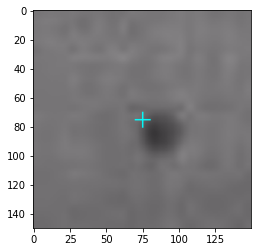

Filtered


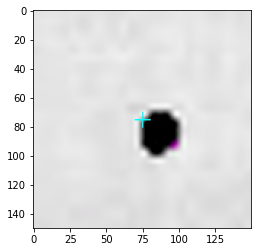

Blurred: 25.632343753043564


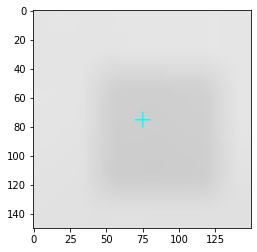

Diff (Float - blurred)


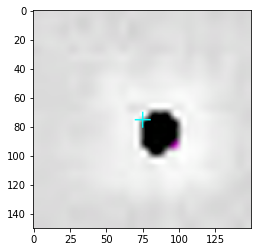

Median


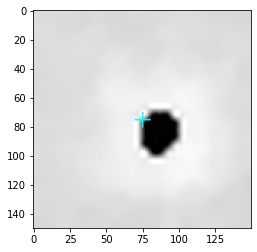

Median filtered


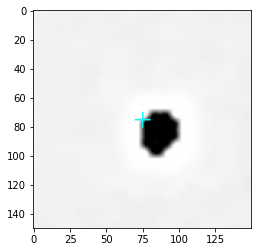

Threshold


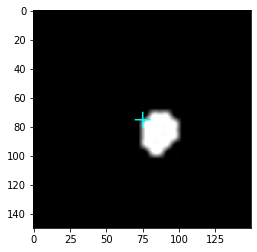

Gaussian


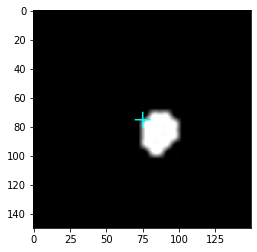

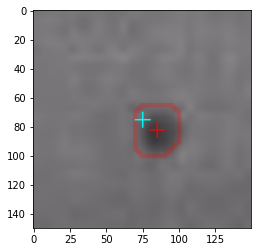

In [10]:
import samtools
working_dir = 'C:/Users/Samuel_DeLap.UMLADCO/Documents/Abu-Zahra/SQ03Cadaver'
cam = 'cam1'
part = 'marker001'
frame_num = 1
hdf_path = 'C:/Users/Samuel_DeLap.UMLADCO/Documents/Abu-Zahra/SQ03Cadaver/trials/18NOV2022SQ3Trial_01/it0/18NOV2022SQ3Trial_01-Predicted2DPoints.h5'
krad = 17
gsigma = 10
img_wt = 3.6
blur_wt = -2.9
gamma = 0.1

samtools.jupyter_test_autocorrect(working_dir=working_dir, cam=cam, marker_name=part, frame_num=frame_num, hdf_path=hdf_path, krad=krad, gsigma=gsigma, img_wt=img_wt, blur_wt=blur_wt, gamma=gamma, threshold=8)